In [2]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
# torch.backends.quantized.engine = 'qnnpack'

Random stuff

In [34]:
with torch.no_grad():
    sub_classes_w = model.classifier[1].weight[:200,:]
    sub_classes_b = model.classifier[1].bias[:200]
    new_layer = torch.nn.Linear(sub_classes_w.size()[1],sub_classes_w.size()[0])
    new_layer.weight[:,:] = sub_classes_w
    new_layer.bias[:] = sub_classes_b
    model.classifier[1] = new_layer


In [ ]:
# model = models.quantization.mobilenet_v2(weights='DEFAULT',quantize=True)
# model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')

training

In [3]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
# model = models.mobilenet_v3_large()
# model.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
# train_loader, val_loader,_ = load_tiny_imagenet(64,1234)
train_loader, val_loader = load_imagenet64(64,12345)
train(model,train_loader,val_loader,'cuda',lr=0.004)

Train Epoch: 0 [0/1153050 (0%)] train loss: 13.635, lr: 0.00400000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 4.795, lr: 0.00392000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 4.491, lr: 0.00384160
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.079, lr: 0.00376477
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.746, lr: 0.00368947
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.375, lr: 0.00361568
Train Epoch: 0 [307200/1153050 (27%)] train loss: 3.794, lr: 0.00354337
Train Epoch: 0 [358400/1153050 (31%)] train loss: 3.695, lr: 0.00347250
Train Epoch: 0 [409600/1153050 (36%)] train loss: 3.782, lr: 0.00340305
Train Epoch: 0 [460800/1153050 (40%)] train loss: 3.466, lr: 0.00333499
Train Epoch: 0 [512000/1153050 (44%)] train loss: 3.622, lr: 0.00326829
Train Epoch: 0 [563200/1153050 (49%)] train loss: 3.353, lr: 0.00320293
Train Epoch: 0 [614400/1153050 (53%)] train loss: 3.204, lr: 0.00313887
Train Epoch: 0 [665600/1153050 (58%)] train loss: 3.215, lr: 0.00307609


100%|██████████| 2002/2002 [00:12<00:00, 159.60it/s]


Train Epoch: 0 [468416/1153050 (100%)] train loss: 3.259, val loss: 3.145, val acc: 0.333, top5: 0.583, lr: 0.00251339
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.3327739488124137
Train Epoch: 1 [0/1153050 (0%)] train loss: 3.121, lr: 0.00251339
Train Epoch: 1 [51200/1153050 (4%)] train loss: 3.241, lr: 0.00246312
Train Epoch: 1 [102400/1153050 (9%)] train loss: 3.343, lr: 0.00241386


KeyboardInterrupt: 

flops

In [166]:
from thop import profile
model = model = models.mobilenet_v3_large()
input = torch.randn(1, 3, 64, 64)
macs, params = profile(model, inputs=(input, ))
print(macs/1e6,params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
22.863256 5483032.0


test sets

In [70]:
test_set = load_imagenet(128,1234,False)
test_set64 = load_imagenet64(128,1234,False)

test_set_corr = load_imagenetc_val(128,1234,corruption='impulse_noise')
test_set_corr64 = load_imagenetc64_val(128,1234,corruption='impulse_noise')

In [69]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [57]:
acc_clean = validate(model,test_set,'cuda')
acc64_clean = validate(model64,test_set64,'cuda')


 12%|█▏        | 5902/50000 [01:02<07:43, 95.07it/s] 


KeyboardInterrupt: 

In [12]:
print("Mobilenet V3 Large Clean (224x224)\n Top 1: {:2.2f}%\t Top 5: {:2.2f}%".format(acc_clean[0]*100,acc_clean[2]*100))
print("Mobilenet V3 Large Clean (64x64)\n Top 1: {:2.2f}%\t Top 5: {:2.2f}%".format(acc64_clean[0]*100,acc64_clean[2]*100))

Mobilenet V3 Large Clean (224x224)
 Top 1: 75.31%	 Top 5: 92.63%
Mobilenet V3 Large Clean (64x64)
 Top 1: 47.64%	 Top 5: 72.79%


In [71]:
val_l = load_imagenetc_val(128,1234,severity=1)
validate(model,val_l,'cuda')

100%|██████████| 391/391 [00:31<00:00, 12.38it/s]


(0.60354, 1.8501898458851573, 0.8296)

In [42]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']
acc_corr = []
acc_corr64 = []

for corr in corruptions:
    corr_set = load_imagenetc_val(128,1234,corr,severity=2)
    corr_set64 = load_imagenetc64_val(128,1234,corr,severity=2)

    acc_corr.append(validate(model,corr_set,'cuda')[0])
    acc_corr64.append(validate(model64,corr_set64,'cuda')[0])
    

100%|██████████| 391/391 [00:05<00:00, 73.57it/s]


In [46]:
import pandas as pd
df = pd.DataFrame(columns=corruptions)
df.loc[0] = acc_corr
df.loc[1] = acc_corr64
df.insert(0, "Model", ['224x224', '64x64'])
df.insert(1,'Clean Acc.',[acc_clean,acc64_clean])
df.insert(2,'Avg Corr. Acc.',[sum(acc_corr)/len(acc_corr),sum(acc_corr64)/len(acc_corr64)])
df.to_csv("accuracy results2.csv")

In [5]:
test_set_cal = load_imagenet(128,1234,False)
test_set64_cal = load_imagenet64(128,1234,False)

model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')

def get_conf_cal(data_loader, model):
    confidences = torch.zeros(len(data_loader.dataset))
    accuracies = torch.zeros(len(data_loader.dataset))

    # load the entire validation set
    idx = 0
    with torch.no_grad():
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = idx*data_loader.batch_size
            end = start + data_loader.batch_size
            if end > len(data_loader.dataset):
                end = len(data_loader.dataset)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            confidences[start:end] = conf
            accuracies[start:end] = acc
            idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs

# accs_cal, confs_cal = get_conf_cal(test_set_cal,model)
accs64_cal, confs64_cal = get_conf_cal(test_set64_cal,model64)

100%|██████████| 391/391 [00:20<00:00, 18.97it/s]


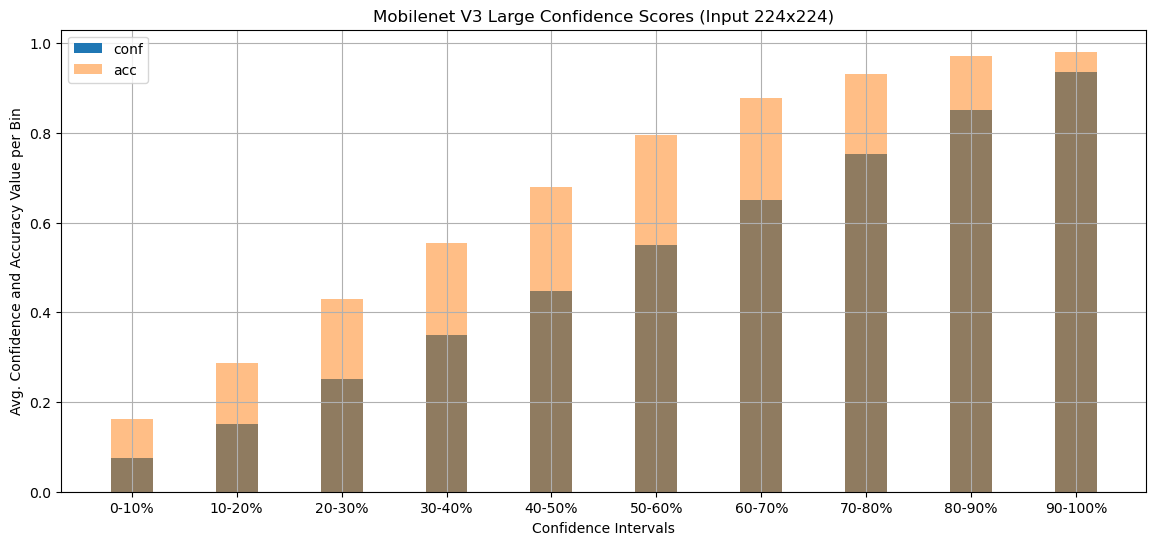

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

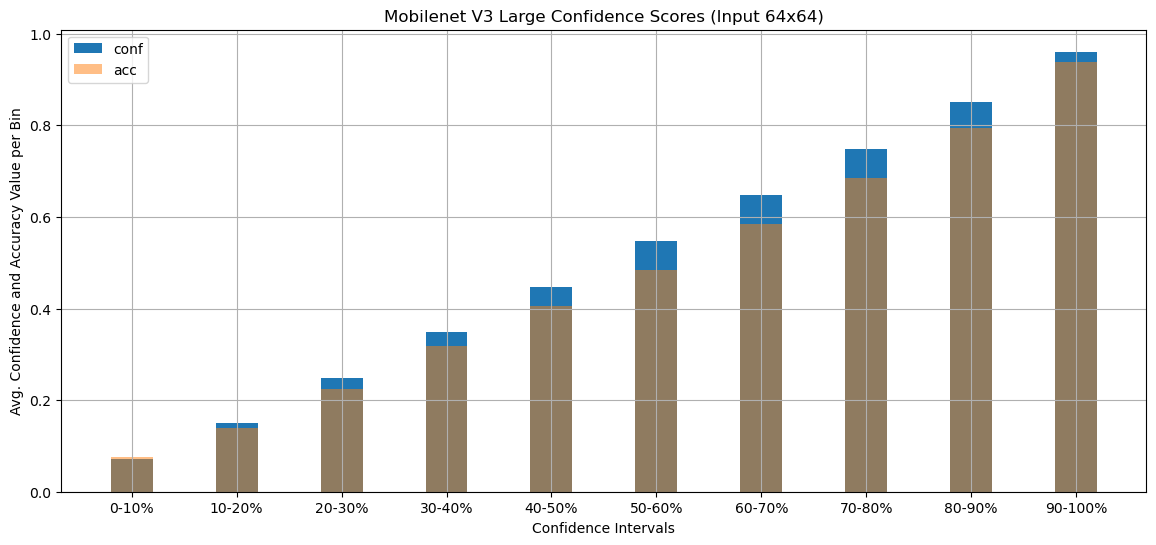

In [24]:
figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs64_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs64_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

In [73]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

def get_conf_cal_corr(data_loaders, model):
    confidences = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    accuracies = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    print(len(confidences))

    # load the entire validation set
    with torch.no_grad():
        for dl_idx, data_loader in enumerate(data_loaders):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                confidences[start:end] = conf
                accuracies[start:end] = acc

                idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        print(in_bin,"/",len(in_bin))

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs

corrs = []
corrs64 = []
for corr in corruptions:
    corrs.append(load_imagenetc_val(128,1234,corr))
    corrs64.append(load_imagenetc64_val(128,1234,corr))

accs_cal, confs_cal = get_conf_cal_corr(corrs,model)
accs64_cal, confs64_cal = get_conf_cal_corr(corrs64,model64)

750000
gaussian_noise


100%|██████████| 391/391 [00:28<00:00, 13.79it/s]


impulse_noise


100%|██████████| 391/391 [00:31<00:00, 12.25it/s]


shot_noise


100%|██████████| 391/391 [00:31<00:00, 12.34it/s]


defocus_blur


100%|██████████| 391/391 [00:28<00:00, 13.93it/s]


glass_blur


100%|██████████| 391/391 [00:24<00:00, 16.19it/s]


motion_blur


100%|██████████| 391/391 [00:27<00:00, 14.00it/s]


zoom_blur


100%|██████████| 391/391 [00:27<00:00, 14.04it/s]


snow


100%|██████████| 391/391 [00:28<00:00, 13.52it/s]


frost


100%|██████████| 391/391 [00:28<00:00, 13.63it/s]


fog


100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


brightness


100%|██████████| 391/391 [00:28<00:00, 13.80it/s]


contrast


100%|██████████| 391/391 [00:27<00:00, 14.05it/s]


elastic_transform


100%|██████████| 391/391 [00:28<00:00, 13.80it/s]


jpeg_compression


100%|██████████| 391/391 [00:27<00:00, 14.25it/s]


pixelate


100%|██████████| 391/391 [00:28<00:00, 13.49it/s]


tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False,  True, False,  ..., False, False,  True]) / 750000
tensor([ True, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True,  True, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
750000
gaussian_noise


100%|██████████| 391/391 [00:05<00:00, 70.99it/s]


impulse_noise


100%|██████████| 391/391 [00:05<00:00, 71.42it/s]


shot_noise


100%|██████████| 391/391 [00:05<00:00, 71.64it/s]


defocus_blur


100%|██████████| 391/391 [00:05<00:00, 72.67it/s]


glass_blur


100%|██████████| 391/391 [00:05<00:00, 71.86it/s]


motion_blur


100%|██████████| 391/391 [00:05<00:00, 73.10it/s]


zoom_blur


100%|██████████| 391/391 [00:05<00:00, 72.90it/s]


snow


100%|██████████| 391/391 [00:05<00:00, 71.18it/s]


frost


100%|██████████| 391/391 [00:05<00:00, 70.47it/s]


fog


100%|██████████| 391/391 [00:05<00:00, 72.57it/s]


brightness


100%|██████████| 391/391 [00:05<00:00, 72.41it/s]


contrast


100%|██████████| 391/391 [00:05<00:00, 73.18it/s]


elastic_transform


100%|██████████| 391/391 [00:05<00:00, 72.95it/s]


jpeg_compression


100%|██████████| 391/391 [00:05<00:00, 73.01it/s]


pixelate


100%|██████████| 391/391 [00:05<00:00, 72.09it/s]

tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([ True, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False,  True, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False,  True]) / 750000
tensor([False, False,  True,  ..., False,  True, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000


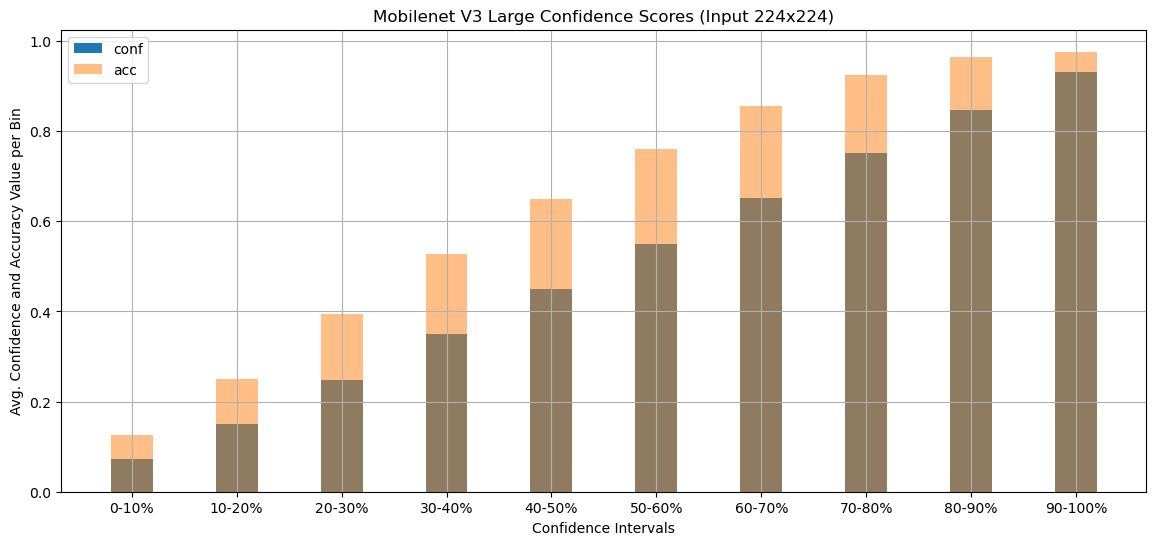

In [75]:
from matplotlib.pyplot import figure
figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

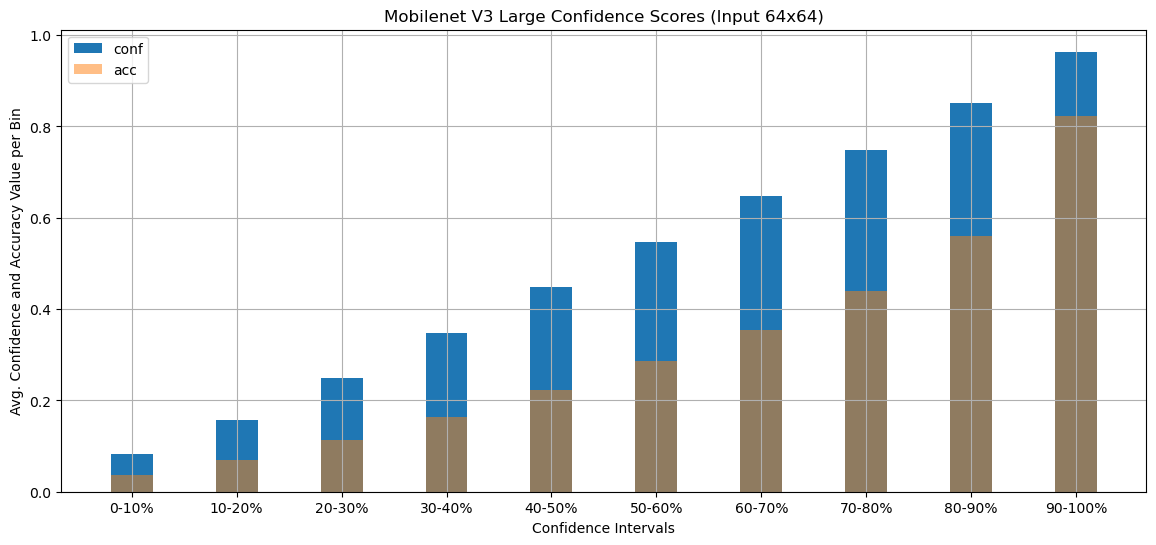

In [76]:
figure(figsize=(14, 6), dpi=100)
bars = ["0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"]
xpos = [0,5,10,15,20,25,30,35,40,45]
plt.bar(xpos,confs64_cal,label="conf",width=2)
plt.xticks(xpos, bars)
plt.bar(xpos,accs64_cal,label="acc",width=2,alpha=0.5)
plt.xticks(xpos, bars)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64)')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.grid()

Online accuracy

In [ ]:
# get all data
corrs = []
corrs64 = []
for corr in corruptions:
    corrs.append(load_imagenetc_val(128,1234,corr))
    corrs64.append(load_imagenetc64_val(128,1234,corr))

clean_set = load_imagenet(128,1234,False)
clean_set64 = load_imagenet64(128,1234,False)

# put all datasets in this order
rand_order = torch.randperm(len(clean_set.dataset))

In [82]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

# clean baseline
clean_online_acc = []
clean_online_acc64 = []
idxs = []
num_imgs = 0
num_correct = 0
num_correct64 = 0
for sample_idx in tqdm(rand_order):
    num_imgs += 1
    # get the image at the specified index
    img,target = clean_set.dataset[sample_idx]
    img64,target64 = clean_set64.dataset[sample_idx]
    img,target = img.to('cuda'),torch.tensor(target).to('cuda')
    img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
    # get the prediction
    pred = model(img.unsqueeze(0)).argmax(dim=1).item()
    pred64 = model64(img64.unsqueeze(0)).argmax(dim=1).item()
    num_correct += (pred == target.item())
    num_correct64 += (pred64 == target64.item())
    clean_online_acc.append(num_correct/num_imgs)
    clean_online_acc64.append(num_correct64/num_imgs)
    idxs.append(num_imgs)


100%|██████████| 50000/50000 [14:48<00:00, 56.30it/s]


In [131]:
# naive strategy
naive_online_acc = []
corr_online_acc = []
corr_online_acc64 = []
idxs = []
num_imgs = 0
num_correct = 0
num_correct64 = 0
num_naive_correct = 0
rand_corr_order = torch.randperm(15)
corr_idx = 0
corr_img_count = 0
num_wrong_decisions = 0
num_choose_itself = 0
num_choose_big = 0
overconfident_locations = []
overconfident_imgs = []
underconfident_locations = []
underconfident_imgs = []
transition_points = [500]
for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 499:
        # each corruption lasts 3300 images
        if corr_img_count == 3300:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corrs[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corrs64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_set.dataset[sample_idx]
        img64,target64 = clean_set64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    # get the prediction
    out = model(img.unsqueeze(0))
    out64 = model64(img64.unsqueeze(0))
    pred = out.argmax(dim=1).item()
    pred64 = out64.argmax(dim=1).item()
    res = (pred == target.item())
    res64 = (pred64 == target64.item())
    num_correct += res
    num_correct64 += res64
    corr_online_acc.append(num_correct/num_imgs)
    corr_online_acc64.append(num_correct64/num_imgs)

    # naive strategy, if less than 50% confident, use big model
    if torch.nn.Softmax()(out64).max().item() < 0.50:
        num_naive_correct += res
        num_choose_big += 1
        # if was underconfident
        if res64:
            num_wrong_decisions += 1
            underconfident_imgs.append(sample_idx)
            underconfident_locations.append(num_imgs)
    else:
        num_naive_correct += res64
        num_choose_itself += 1
        # if was overconfident
        if not res64 and res:
            num_wrong_decisions += 1
            overconfident_imgs.append(sample_idx)
            overconfident_locations.append(num_imgs)
    naive_online_acc.append(num_naive_correct/num_imgs)
    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_3475947/3843487387.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if torch.nn.Softmax()(out64).max().item() < 0.50:
100%|██████████| 50000/50000 [11:29<00:00, 72.50it/s]


Text(0.5, 0, 'Image Index')

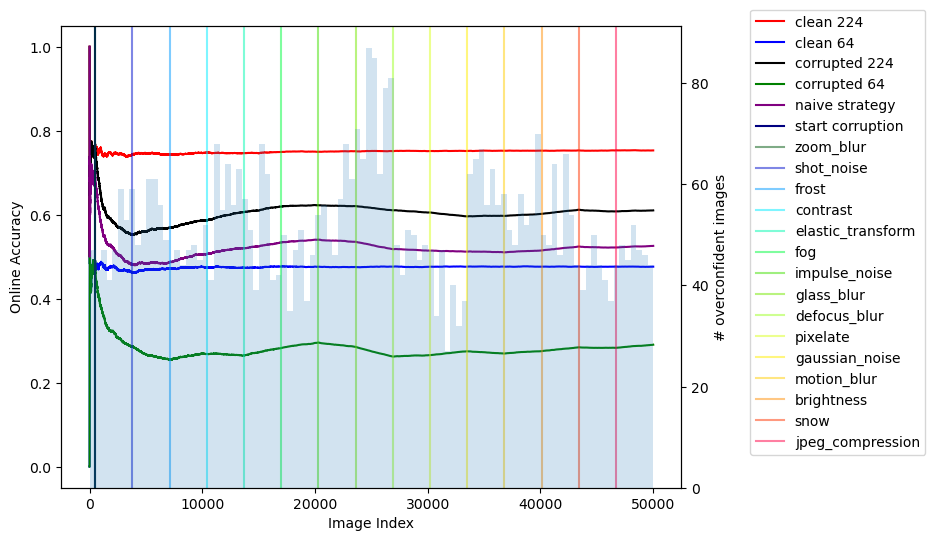

In [163]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_acc,label='clean 224',color='red')
ax1.plot(idxs,clean_online_acc64,label='clean 64',color='blue')
ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,naive_online_acc,label='naive strategy',color='purple')
ax1.axvline(x = 499, color = 'orange', label = 'start corruption')
for i,x in enumerate(transition_points):
    plt.axvline(x =x, label = corruptions[rand_corr_order[i]],alpha=0.5)
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines[5:]):
    j.set_color(colors[i])
ax2 = ax1.twinx()
px = overconfident_locations
py = [naive_online_acc[x] for x in px]
# plt.scatter(px,py,s=0.5,c='r')
ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
ax1.set_ylabel("Online Accuracy")
ax2.set_ylabel("# overconfident images")
ax1.set_xlabel("Image Index")

In [144]:
len(underconfident_imgs)

4098

Quantization Stuff

In [160]:
model = models.quantization.mobilenet_v3_large()
model.fuse_model(is_qat=True)
model.qconfig = torch.ao.quantization.get_default_qat_qconfig('qnn_pack')
torch.ao.quantization.prepare_qat(model, inplace=True)

checkpoint = torch.load('classification/model_49.pth',map_location="cpu")
model.load_state_dict(checkpoint["model"])


torch.quantization.convert(model, inplace=True)
# print(model)
model.eval()

model.to('cpu')
d,t = next(iter(val))
pred=model(d).argmax(dim=1, keepdim=True)
pred.eq(t.view_as(pred)).sum().item()

/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torch/ao/quantization/utils.py:287: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


NameError: name 'val' is not defined

Online Accuracy test

In [56]:
model = models.mobilenet_v2(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v2()
model64.load_state_dict(torch.load('best_models/best_batch_i198187.pth')['model_state_dict'])
model64.to('cuda')

test_loader = load_imagenet(128,123,False)
test_loader64 = load_imagenet64(128,123,False)

# print("OG model", validate(model,test_loader,'cuda'))
print("64 model", validate(model64,test_loader64,'cuda'))


100%|██████████| 391/391 [00:20<00:00, 18.97it/s]

64 model (0.26852, 3.7743131181468135, 0.50334)


In [ ]:
model.eval()
val_loss = 0
correct = 0
correct5 = 0

with torch.no_grad():
    i=0
    for data, target in tqdm(val_loader):
        data, target = data.to(device), target.to(device)

        # Forward
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        val_loss += nn.CrossEntropyLoss()(output, target).item()  # sum up batch loss
        correct += pred.eq(target.view_as(pred)).sum().item()

        batch_size = target.size(0)

        _, pred_top5 = torch.topk(output, 5, 1, True, True)
        pred_top5 = pred_top5.t()
        correct_top5 = pred_top5.eq(target.view(1, -1).expand_as(pred_top5))

        correct5 += correct_top5[:5].reshape(-1).float().sum(0).item()
        i+=1
        
    # Compute loss and accuracy
    val_loss /= len(val_loader) # cross entropy returns batch mean
    val_acc = correct / len(val_loader.dataset)
    val_acc_top5 = correct5 / len(val_loader.dataset)